In [1]:
import sys
sys.path.insert(0,"../")
import numpy as np 
import json 
import matplotlib.pyplot as plt
import jax.numpy as jnp
import pandas as pd 

In [2]:
with open("./results/SS_2.json","r") as f: 
    dct = json.load(f)

In [3]:
ps = np.array(json.loads(dct["ps"]))
ps = ps.reshape(-1,ps.shape[-2],ps.shape[-1])
qb = np.array(json.loads(dct["qb"]))
qb_mask = np.array(json.loads(dct["qb_mask"]))
plot_mask = np.where(qb_mask==True)[0]

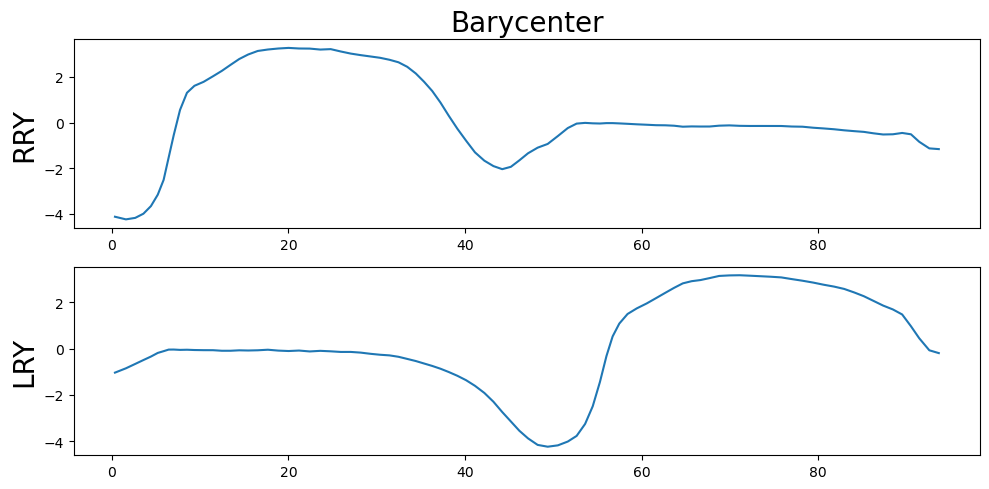

In [4]:
plot_qb = qb[np.where(qb_mask==True)[0]].T
labels = ["RRY", "LRY"]
fig,axs = plt.subplots(2,1,figsize=(10,5))
for i,lbl in enumerate(labels): 
    axs[i].plot(plot_qb[0],plot_qb[i+1])
    axs[i].set_ylabel(lbl,fontsize=20)
axs[0].set_title("Barycenter",fontsize=20)
fig.tight_layout()


In [5]:
dataset = np.load("./dataset/X.npy")
masks = np.load("./dataset/X_mask.npy")
metadata = pd.read_csv("./dataset/metadata.csv",index_col=0)
y = np.load("./dataset/y.npy")

## Momenta PCA

In [6]:
from src.statistic import MomentaPCA
from src.kernel import VFTSGaussKernel
from src.lddmm import Shooting

In [7]:
n_comp = 5
n_disp = 5
n_ps = 700

Kv = VFTSGaussKernel(1,0.1,30,1,1)

mpca = MomentaPCA(n_comp,False,"cov")
mpca.fit(Kv,ps[:n_ps],qb,qb_mask)
mpca.p_std_

array([27.300009 , 13.581614 ,  9.144741 ,  7.3664775,  6.6499066],
      dtype=float32)

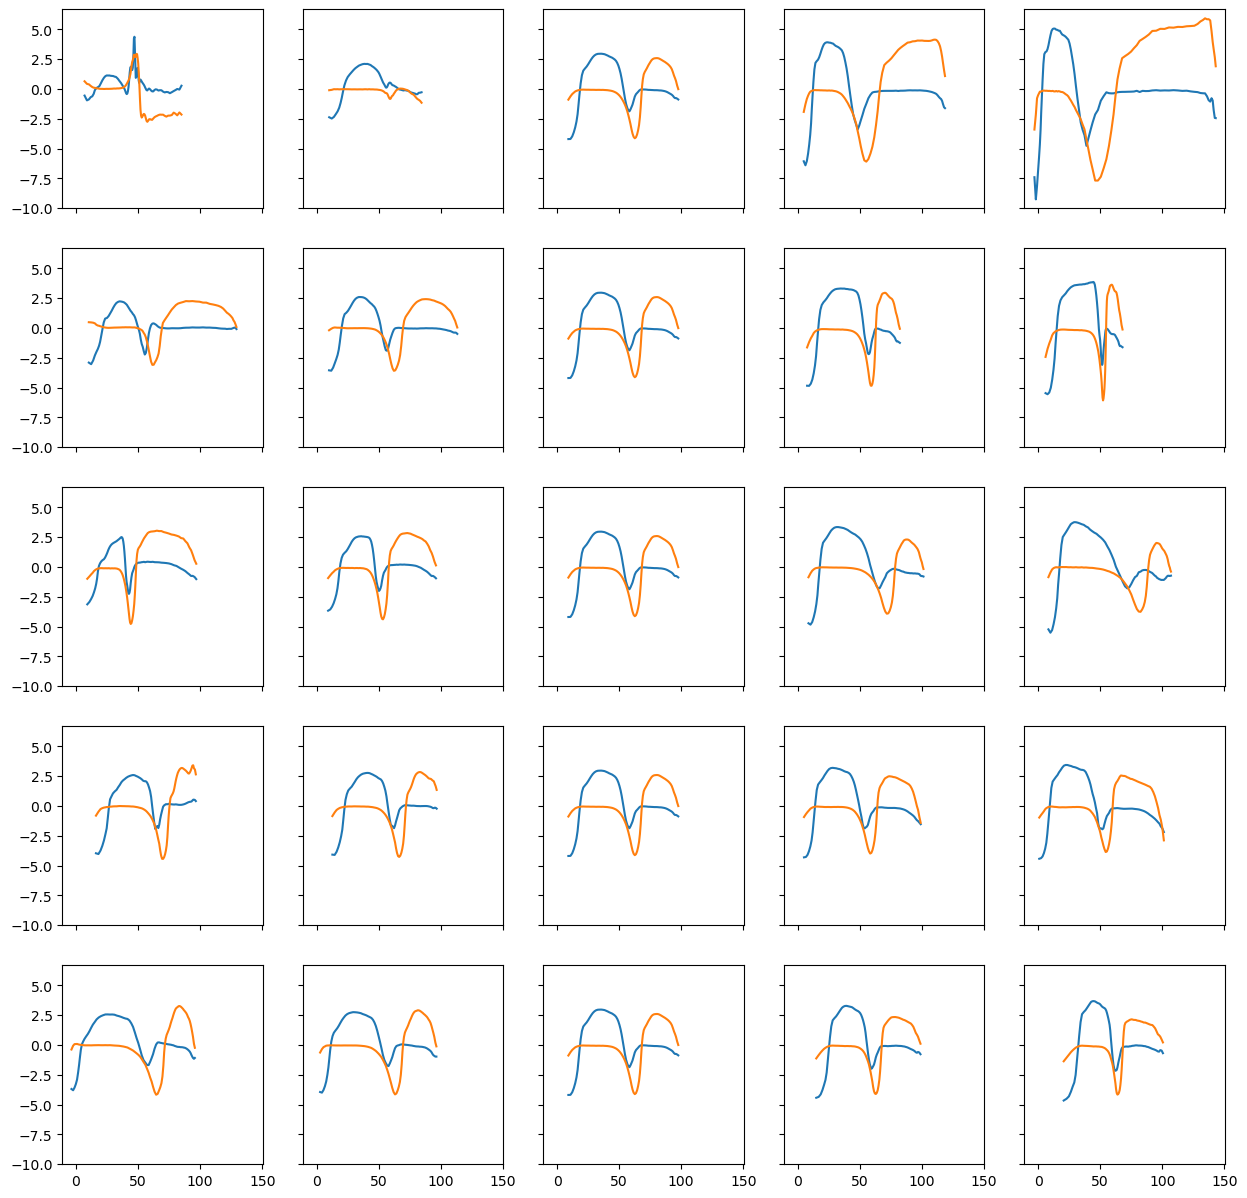

In [8]:
shoot = Shooting(Kv)
p0_b = mpca.m_ps_
fig,axs = plt.subplots(n_comp,n_disp,figsize = (n_disp*3,n_comp*3),sharex=True,sharey=True)
for pca_index in range(n_comp):
    sigma_pca = mpca.p_std_[pca_index]
    for j,alpha in enumerate(np.linspace(-3*sigma_pca , 3*sigma_pca, n_disp)):
        p0_mode = p0_b + alpha * mpca.p_pc_[pca_index]
        _,q = shoot(p0_mode,qb,qb_mask)
        plot_q = q[plot_mask].T
        axs[pca_index,j].plot(plot_q[0],plot_q[1])
        axs[pca_index,j].plot(plot_q[0],plot_q[2])

In [9]:
y

array(['Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Neurological', 'Neurological',
       'Neurological', 'Neurological', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
   

In [10]:
from sklearn.preprocessing import OrdinalEncoder

In [11]:
metadata.head()

,Subject,Trial,Code,Age,Gender,Height,Weight,BMI,Laterality,Sensor,WalkedDistance,WalkingSpeed,PathologyGroup,IsControl
0,1,1,1-1,70,F,1.65,72,26.4,Right,TCon,10.0,1.3,Neurological,No
1,1,2,1-2,70,F,1.65,72,26.4,Right,TCon,10.0,1.3,Neurological,No
2,1,3,1-3,70,F,1.65,72,26.4,Right,TCon,10.0,1.4,Neurological,No
3,1,4,1-4,70,F,1.65,72,26.4,Right,TCon,10.0,1.1,Neurological,No
4,1,5,1-5,70,F,1.65,72,26.4,Right,TCon,10.0,1.3,Neurological,No


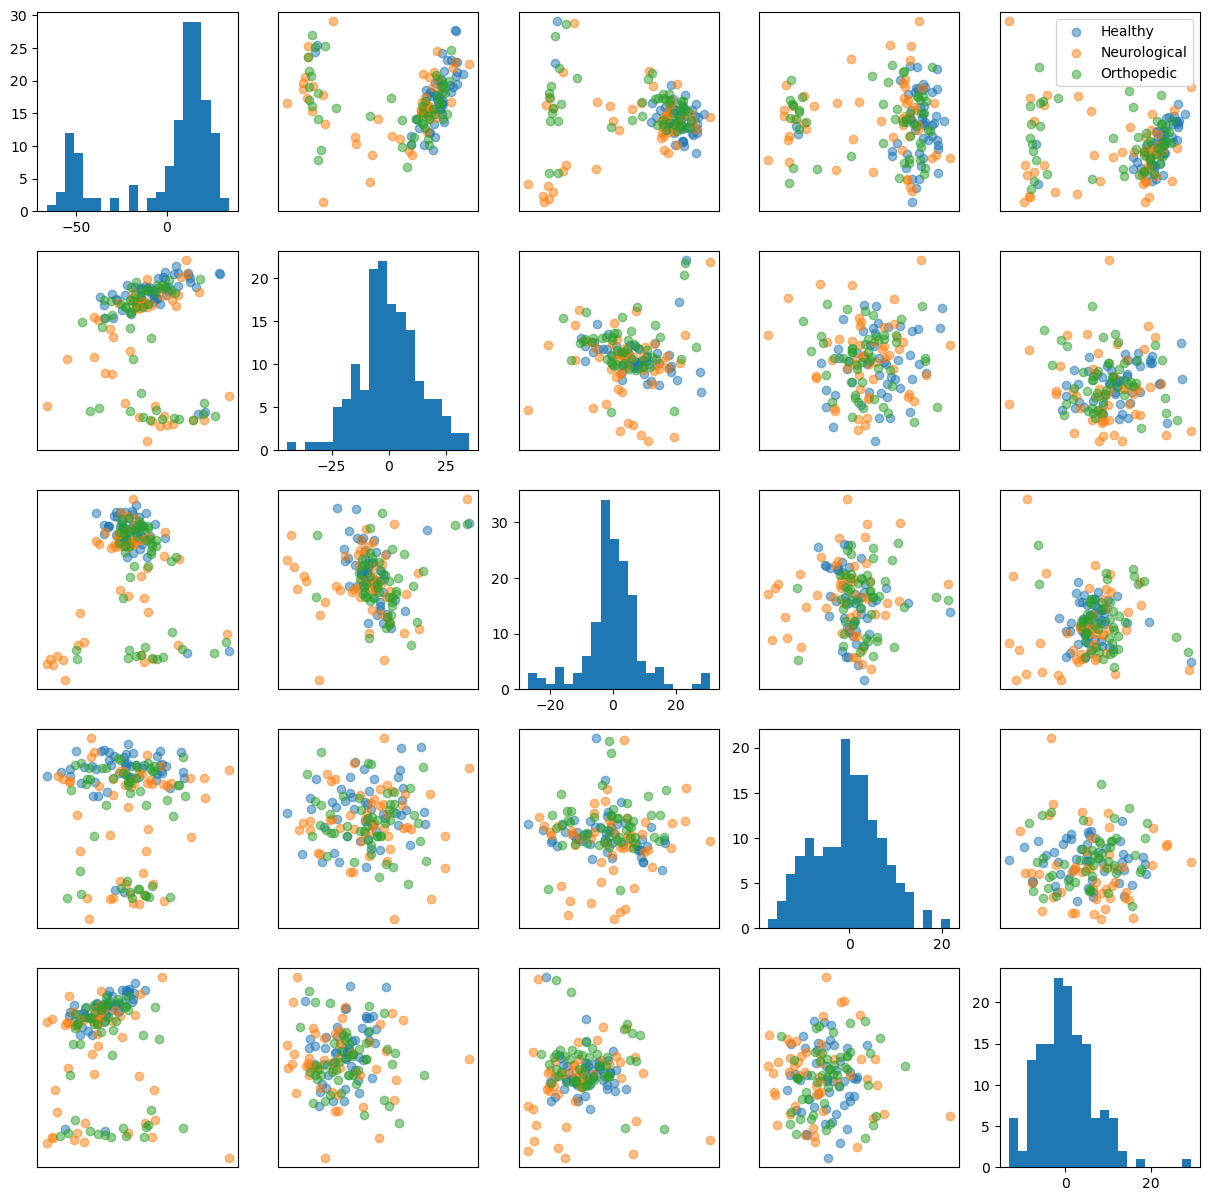

: 

In [12]:
oe = OrdinalEncoder()
label = oe.fit_transform(y.reshape(-1,1)).squeeze()
categories = oe.categories_[0]

fig,axs = plt.subplots(n_comp,n_comp,figsize = (n_comp*3,n_comp*3))
for i in range(n_comp): 
    for j in range(i,n_comp):
        if i!=j: 
            for k,c in enumerate(categories):
                idx = np.where(label==k)[0]
                axs[i,j].scatter(mpca.p_score_[idx,i],mpca.p_score_[idx,j],label = c,alpha=0.5)
                axs[j,i].scatter(mpca.p_score_[idx,j],mpca.p_score_[idx,i],label=c,alpha=0.5)
                axs[i,j].set_xticks([])
                axs[i,j].set_yticks([])
                axs[j,i].set_xticks([])
                axs[j,i].set_yticks([])
        else: 
            axs[i,i].hist(mpca.p_score_[:,i],bins=20)

axs[0,-1].legend()
